In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import json


In [2]:
in_dir = '../data/'
#game = '89ffea6b-5a85-287d-9aab-7cf698f35ebd-data/data/' # 0.6, 0.5, M = 4
#game = '516af3c0-e39a-99f5-c24d-f7072dd65aef-data/data/' # 0.6, 0.5, M = 10
#game = 'b9865161-8385-c96e-1455-1395e0204886-data/data/' # 0.7., 0.4, M = 10
#game = '12837ab1-6e87-4471-fe73-8285a4251905-data/data/' # 0.6, 0.2, M = 10
#game = '7e81b66d-107c-ddc9-4002-eeda7ea82675-data/data/' # 0.6, 0.2, M = 20
#game = '432bb267-c06d-55e0-f44f-394375ed3ce3-data/data/' # 0.6, 0.3, M = 4
#game = '9abf70d3-4ad0-43f7-a430-4538782c3160-data/data/' # 0.6, 0.3, M = 20, T = 3
games = [
    '5aa2346f-cef8-9bbc-5eb9-ba97f76b76ed-data/data/', # 0.6, 0.3, M = 20, T = 10
    'd3ffdda3-b0c3-a671-76d0-e2c3206afbff-data/data/', # 0.6, 0.3, M = 20, T = 10
    'c40e84e2-86a3-a44b-1726-d1a9e1f1d715-data/data/', # 0.6, 0.3, M = 20, T = 10
]
    
binary = True
pilot = False
pos_p = 0.6
neg_p = 0.3

In [23]:
infos_dict = {} 
for g in games:
    infos_dict[g] = pd.read_csv(in_dir + g + 'info.csv')
    participants = pd.read_csv(in_dir + g + 'participant.csv')
    print(sum(participants['status'] == 'approved'), sum(participants['status'] != 'approved'))

200 90
200 93
200 88


In [4]:
for g in games:
    infos = infos_dict[g]
    infos['shift'] = np.nan
    infos['quiz_attempts'] = np.nan
    for i in range(len(infos)):
        row_info = json.loads(infos.iloc[i]['contents'])
        infos.loc[i,'shift'] = row_info['shift']
        try:
            infos.loc[i,'quiz_attempts'] = float(row_info['quiz_attempts'])
        except Exception as e:
            pass

4 11
shift
0.0          NaN
1.0     2.150000
2.0     1.904762
3.0     2.100000
4.0     2.045455
5.0     2.333333
6.0     2.228916
7.0     2.400000
8.0     1.966292
9.0     1.696629
10.0    2.000000
Name: quiz_attempts, dtype: float64
4 11
shift
0.0          NaN
1.0     1.850000
2.0     2.034884
3.0     1.793478
4.0     2.100000
5.0     1.764706
6.0     1.773810
7.0     2.160920
8.0     1.890244
9.0     1.717647
10.0    2.021739
Name: quiz_attempts, dtype: float64
4 11
shift
0.0          NaN
1.0     1.750000
2.0     1.747475
3.0     1.920455
4.0     1.807229
5.0     2.000000
6.0     2.096386
7.0     2.154762
8.0     1.989130
9.0     1.717647
10.0    1.350000
Name: quiz_attempts, dtype: float64


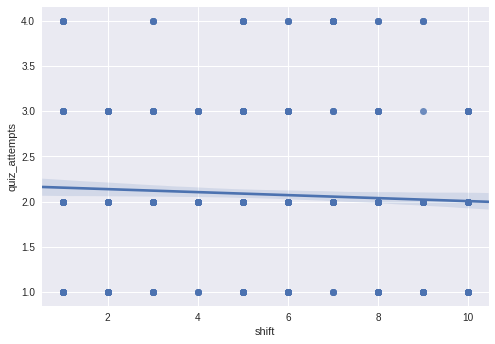

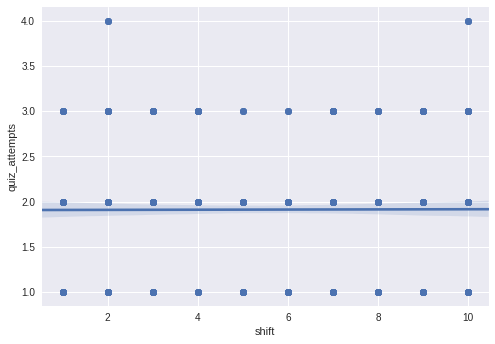

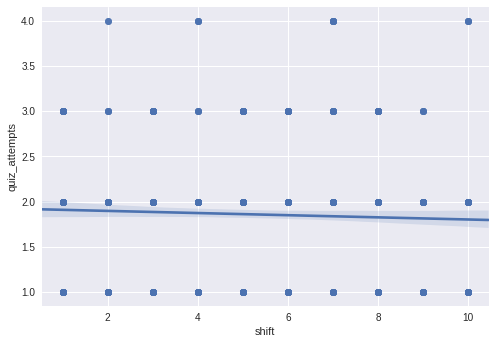

In [5]:
for g in games:
    
    infos = infos_dict[g]
    
    n_nets = max(infos['network_id'])
    n_shifts = int(max(infos['shift']) + 1)
    
    print(n_nets, n_shifts)
    
    print(infos['quiz_attempts'].groupby(infos['shift']).mean())
    
    plt.figure()
    sns.regplot(infos['shift'], infos['quiz_attempts'])

In [6]:
num_seen = []

for g in games:
    
    infos = infos_dict[g]
    
    for net in range(1,n_nets+1):
        
        for shift in range(1,n_shifts):

            init = infos.loc[(infos['network_id'] == net) & (infos['shift'] == shift)]

            for i,row in init.iterrows():

                seen = json.loads(row['contents'])['seen']
                if shift > 1:
                    num_seen += [len(seen)]

asocial_p = np.mean(np.array(num_seen) == 1)

print(asocial_p)

0.775377969762


In [7]:
df = []
nodes = []

for g in games:
    
    infos = infos_dict[g]
    
    for net in range(1,n_nets+1):

        print('\n###################\n')

        print('Network:', net)

        init = infos.loc[(infos['network_id'] == net) & (infos['shift'] == 0) & infos['time_of_death'].isnull()]

        true_class = json.loads(init.iloc[0]['contents'])['true_class']
        classes = json.loads(init.iloc[0]['contents'])['classes']

        print('True Class:', true_class)
        print('Classes:', classes)


        total_evidence = {}
        for c in classes:
            total_evidence[c] = 0

        last_pops = {}
        for c in classes:
            last_pops[c] = 0


        for shift in range(1,n_shifts):

            choices = []

            print('\nShift', shift)

            init = infos.loc[(infos['network_id'] == net) & (infos['shift'] == shift) & infos['time_of_death'].isnull()]

            nodes += [[shift, len(init)]]

            print('Nodes:', len(init))

            for i,row in init.iterrows():

                print('\nParticipant:',i,'\n')

                choice = json.loads(row['contents'])['choice']
                tests = json.loads(row['contents'])['tests'][shift-1]
                seen = json.loads(row['contents'])['seen']

                print('Evidence:', tests)
                print('Seen:', seen)
                print('Decisions:', json.loads(row['contents'])['decisions'])
                print('Choice:', choice)

                choices += [choice]

                #p(c = true | evidence) = p(evidence | c = true) = p_t^{#c} * (1-p_t)^{#~c} 

            if not binary:
                true_class = [true_class]
                choices = [[x] for x in choices]

            choices = np.array(choices)

            print()

            for c in classes:

                if shift > 1:
                    up_to_last = total_evidence[c]/(4.0 * (shift-1))
                    last_pop = last_pops[c]
                else:
                    up_to_last = np.nan
                    last_pop = 0.5

                evidence = sum(np.array([x for l in tests for x in l]) == c)
                total_evidence[c] += evidence

                prop = total_evidence[c]/(4.0 * shift)
                pop = np.sum(np.array([x for l in choices for x in l]) == c)/float(len(init))
                last = evidence/4.0
                total_neg = 4.0 * shift - total_evidence[c]
                post = total_evidence[c] * np.log(pos_p) + total_neg * np.log(1 - pos_p) 
                post -= np.log(np.exp(post) + np.exp(total_evidence[c] * np.log(neg_p) + total_neg * np.log(1 - neg_p)))
                post = np.exp(post)
                assert ~np.isnan(post)

                non_social_prob_match = last

                non_social_post_match = pos_p ** evidence * (1 - pos_p) ** (4 - evidence)
                non_social_post_match /= (non_social_post_match + neg_p ** evidence * (1 - neg_p) ** (4 - evidence))

                non_social_max = round(non_social_post_match)

                social_no_evidence = last_pop

                last_pop = last_pop * (1 - asocial_p) + 0.5 * asocial_p

                social_prob_match = last_pop * last / (last_pop*last + (1-last_pop)*(1 - last))

                social_post_match = last_pop * pos_p ** evidence * (1 - pos_p) ** (4 - evidence)
                social_post_match /= (social_post_match + (1 - last_pop) * neg_p ** evidence * (1 - neg_p) ** (4 - evidence))

                #social_max = 

                last_pops[c] = pop

                print(c)
                print('Evidence:', last)
                print('Total Evidence:', prop)
                print('Popularity:', pop, '\n')

                if net > 2 and shift > 1:
                    df += [[up_to_last, prop, last, post, pop, c, shift, net, g + '-' + str(net), g,
                            non_social_prob_match,
                            non_social_post_match,
                            non_social_max,
                            social_no_evidence,
                            social_prob_match,
                            social_post_match
                           ]]




###################

Network: 1
True Class: ['cezubal', 'yevapa', 'bokisti', 'finoy']
Classes: ['fatometh', 'goayso', 'cezubal', 'yevapa', 'bokisti', 'avuy', 'finoy', 'beunka']

Shift 1
Nodes: 20

Participant: 2 

Evidence: [['finoy', 'cezubal', 'yevapa', 'beunka', 'bokisti'], ['avuy', 'yevapa', 'bokisti', 'goayso', 'finoy'], ['cezubal', 'bokisti', 'avuy'], ['cezubal', 'avuy', 'bokisti', 'yevapa', 'finoy', 'beunka']]
Seen: []
Decisions: [[1, ['bokisti', 'cezubal', 'yevapa', 'finoy', 'beunka']], [2, ['bokisti', 'cezubal', 'yevapa', 'goayso', 'finoy', 'beunka']], [3, ['bokisti', 'cezubal', 'yevapa', 'goayso', 'finoy']], [4, ['bokisti', 'cezubal', 'yevapa', 'finoy']]]
Choice: ['bokisti', 'cezubal', 'yevapa', 'finoy']

Participant: 11 

Evidence: [['finoy', 'bokisti', 'cezubal', 'beunka', 'yevapa'], ['finoy', 'yevapa', 'avuy', 'bokisti', 'goayso'], ['avuy', 'bokisti', 'cezubal'], ['finoy', 'yevapa', 'beunka', 'cezubal', 'bokisti', 'avuy']]
Seen: []
Decisions: [[1, ['cezubal', 'bokisti', '

In [8]:
nodes

[[1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 [10, 20],
 [1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 [10, 20],
 [1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 [10, 20],
 [1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 [10, 20],
 [1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 [10, 20],
 [1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 [10, 20],
 [1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 [10, 20],
 [1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 [10, 20],
 [1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 [10, 20],
 [1, 20],
 [2, 20],
 [3, 20],
 [4, 20],
 [5, 20],
 [6, 20],
 [7, 20],
 [8, 20],
 [9, 20],
 

In [9]:
models = [
    'Nonsocial Probability Matching',
    'Nonsocial Bayesian Probability Matching',
    'Nonsocial Utility Maximizing',
    'Naive Copying',
    'Social Sampling (Probability Matching)',
    'Social Sampling (Bayesian)'
]

df = pd.DataFrame(df)
df.columns = ['Up to Last Evidence','Total Evidence', 'Last Evidence', 'Posterior', 'Popularity', 'Class', 'Shift', 'Net', 'Game Net', 'Game'] + models
print(df)

     Up to Last Evidence  Total Evidence  Last Evidence  Posterior  \
0               0.750000        0.875000           1.00   0.986513   
1               0.250000        0.375000           0.50   0.327693   
2               0.500000        0.625000           0.75   0.856545   
3               0.750000        0.750000           0.75   0.954334   
4               0.250000        0.500000           0.75   0.630445   
5               0.750000        0.625000           0.50   0.856545   
6               0.250000        0.500000           0.75   0.630445   
7               0.750000        0.625000           0.50   0.856545   
8               0.875000        0.833333           0.75   0.997018   
9               0.375000        0.250000           0.00   0.049402   
10              0.625000        0.666667           0.75   0.964658   
11              0.750000        0.666667           0.50   0.964658   
12              0.500000        0.666667           1.00   0.964658   
13              0.62

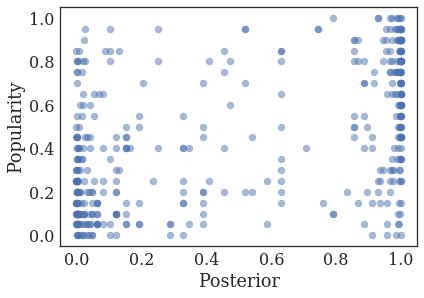

In [10]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')
plt.scatter(df['Posterior'],df['Popularity'], s = 50, alpha = 0.5)
plt.xlabel('Posterior')
plt.ylabel('Popularity')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.savefig('../plots/exp-1-post-pop.pdf', bbox_inches='tight')

In [11]:
print(np.corrcoef(df['Posterior'],df['Popularity']))

[[ 1.          0.53122854]
 [ 0.53122854  1.        ]]


432


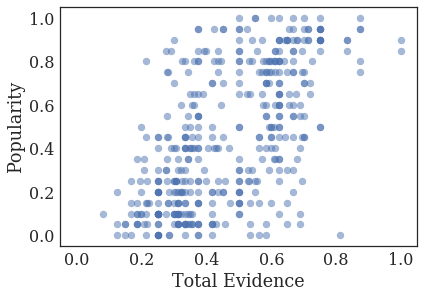

In [12]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')
plt.scatter(df['Total Evidence'],df['Popularity'], s = 50, alpha = 0.5)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.xlabel('Total Evidence')
plt.ylabel('Popularity')
plt.savefig('../plots/exp-1-evi-pop.pdf', bbox_inches='tight')
print(len(df))

In [13]:
print(np.corrcoef(df['Total Evidence'],df['Popularity']))

[[ 1.          0.60059687]
 [ 0.60059687  1.        ]]


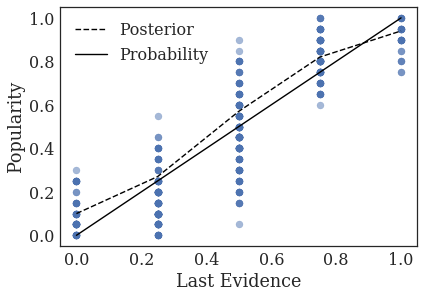

In [14]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')
plt.plot([0,0.25,0.5,0.75,1.0], [0.1, 0.27, 0.57, 0.82, 0.94], c = 'black', linestyle = '--', label = 'Posterior')
plt.plot([0,0.25,0.5,0.75,1.0], [0,0.25,0.5,0.75,1.0], c = 'black', label = 'Probability')
plt.scatter(df['Last Evidence'],df['Popularity'], s = 50, alpha = 0.5, label = '')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.xlabel('Last Evidence')
plt.ylabel('Popularity')
plt.legend()
plt.savefig('../plots/exp-1-last-pop.pdf', bbox_inches='tight')

In [15]:
print(np.corrcoef(df['Last Evidence'],df['Popularity']))

[[ 1.          0.88356347]
 [ 0.88356347  1.        ]]


In [16]:
response_curve = df['Popularity'].groupby(df['Last Evidence']).mean()
resp_z = df['Last Evidence'].replace(response_curve)

In [17]:
response_curve

Last Evidence
0.00    0.101786
0.25    0.169828
0.50    0.473022
0.75    0.823370
1.00    0.906897
Name: Popularity, dtype: float64

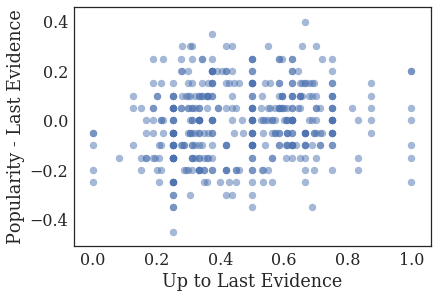

In [18]:
sns.set(context = 'paper', font_scale = 2, font='serif', style = 'white')
plt.scatter(df['Up to Last Evidence'],df['Popularity'] - df['Last Evidence'], s = 50, alpha = 0.5)
#plt.xlim(-0.05,1.05)
#plt.ylim(-0.05,1.05)
plt.xlabel('Up to Last Evidence')
plt.ylabel('Popularity - Last Evidence')
plt.savefig('../plots/exp-1-prior-diff.pdf', bbox_inches='tight')

In [19]:
print(np.corrcoef(df['Up to Last Evidence'],df['Popularity'] - df['Last Evidence']))

[[ 1.          0.15493996]
 [ 0.15493996  1.        ]]


In [20]:
import os
if pilot:
    df.to_csv('pilot-data.csv')
    os.system('Rscript pilot-analysis.R > tmp')
    with open('tmp') as f:
        print('Statistical power of 11 independent samples: ', f.readlines())
else:
    df.to_csv('data.csv')
    os.system('Rscript analysis.R > tmp')
    with open('tmp') as f:
        print(''.join(f.readlines()))


Preregistered Test

Call:
lm(formula = Popularity ~ Total.Evidence + Last.Evidence + Game.Net, 
    data = sub.df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27215 -0.08852 -0.01580  0.09471  0.32418 

Coefficients:
                                                          Estimate Std. Error
(Intercept)                                               -0.05691    0.06027
Total.Evidence                                             0.22354    0.11017
Last.Evidence                                              0.84525    0.05624
Game.Net5aa2346f-cef8-9bbc-5eb9-ba97f76b76ed-data/data/-4  0.16410    0.04777
Game.Netc40e84e2-86a3-a44b-1726-d1a9e1f1d715-data/data/-3  0.00446    0.04090
Game.Netc40e84e2-86a3-a44b-1726-d1a9e1f1d715-data/data/-4  0.03559    0.04608
Game.Netd3ffdda3-b0c3-a671-76d0-e2c3206afbff-data/data/-3  0.03392    0.04378
Game.Netd3ffdda3-b0c3-a671-76d0-e2c3206afbff-data/data/-4  0.02889    0.04811
                                                          t val

432
Nonsocial Probability Matching Correlation: 0.883563469325
Nonsocial Bayesian Probability Matching Correlation: 0.900135428753
Nonsocial Utility Maximizing Correlation: 0.782433906334
Naive Copying Correlation: 0.357893247134
Social Sampling (Probability Matching) Correlation: 0.902532662328
Social Sampling (Bayesian) Correlation: 0.916477482388

Nonsocial Probability Matching MSE: 9.215
Nonsocial Bayesian Probability Matching MSE: 9.49450607761
Nonsocial Utility Maximizing MSE: 52.69
Naive Copying MSE: 54.425
Social Sampling (Probability Matching) MSE: 7.78524230042
Social Sampling (Bayesian) MSE: 7.73193145212


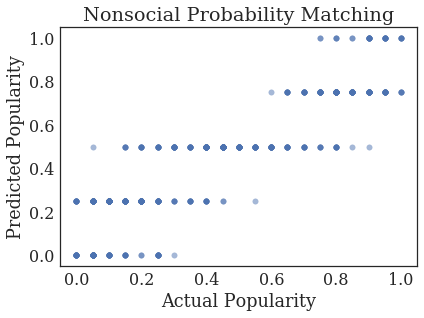

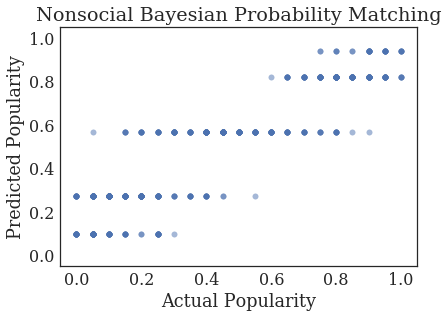

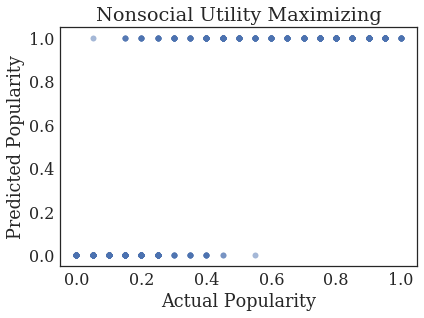

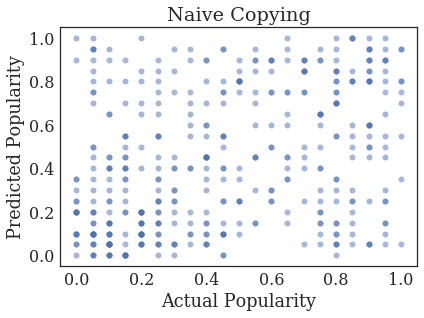

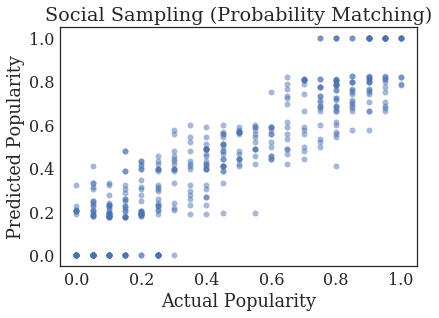

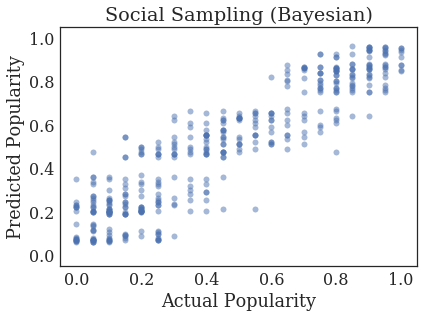

In [21]:
print(len(df))

for m in models:
    print(m, 'Correlation:', np.corrcoef(df[m],df['Popularity'])[0,1])
    
print()

for m in models:
    plt.figure()
    plt.scatter(df['Popularity'], df[m], alpha = 0.5)
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.ylabel('Predicted Popularity')
    plt.xlabel('Actual Popularity')
    plt.title(m)
    plt.savefig('../plots/exp-1-' + '-'.join(m.split(' ')) + '.pdf', bbox_inches='tight')
    print(m, 'MSE:', sum((df[m] - df['Popularity'])**2))

Nonsocial Probability Matching MSE: 9.215
Nonsocial Bayesian Probability Matching MSE: 9.49450607761
Nonsocial Utility Maximizing MSE: 52.69
Naive Copying MSE: 54.425
Social Sampling (Probability Matching) MSE: 7.78524230042
Social Sampling (Bayesian) MSE: 7.73193145212


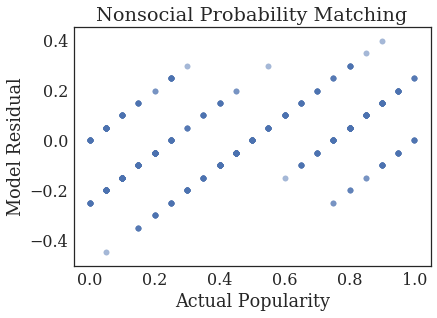

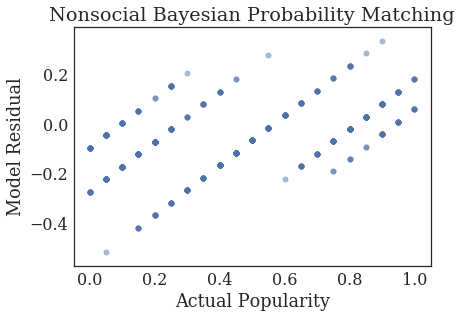

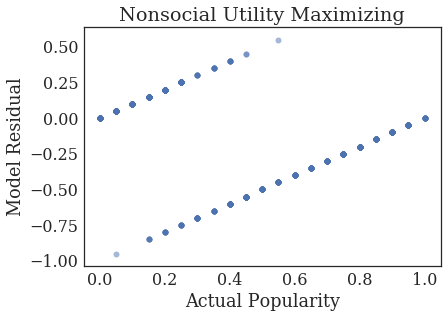

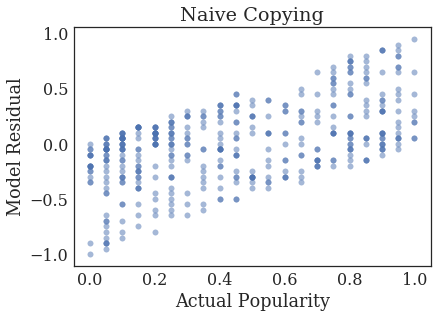

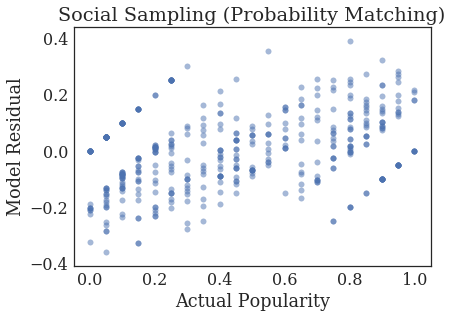

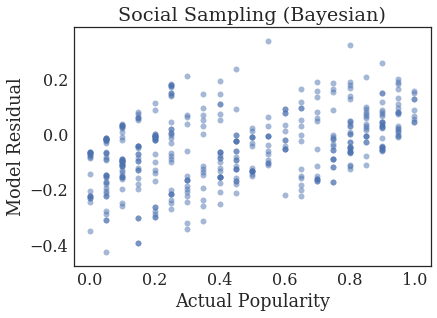

In [22]:
for m in models:
    plt.figure()
    plt.scatter(df['Popularity'], df['Popularity'] - df[m], alpha = 0.5)
    plt.xlim(-0.05,1.05)
    plt.xlabel('Actual Popularity')
    plt.ylabel('Model Residual')
    plt.title(m)
    plt.savefig('../plots/exp-1-' + '-'.join(m.split(' ')) + '-residual.pdf', bbox_inches='tight')
    print(m, 'MSE:', sum((df[m] - df['Popularity'])**2))